In [35]:

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Load the dataset 
file_path = 'all_stocks_5yr.csv'
df = pd.read_csv(file_path)

# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'])

# Select 6 diverse companies
selected_tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'JPM', 'JNJ']
df_selected = df[df['Name'].isin(selected_tickers)]

# Pivot to multivariate format 
df_wide = df_selected.pivot(index='date', columns='Name', values='close').sort_index()

# Inspect the resulting dataset
print("Shape of multivariate dataset:", df_wide.shape)
print("Date range:", df_wide.index.min(), "to", df_wide.index.max())
print("\nMissing values per company:\n", df_wide.isnull().sum())


Shape of multivariate dataset: (1259, 6)
Date range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00

Missing values per company:
 Name
AAPL      0
AMZN      0
GOOG    284
JNJ       0
JPM       0
MSFT      0
dtype: int64


In [3]:
# Interpolate missing values using linear interpolation (forward + backward filling)
df_wide_interpolated = df_wide.interpolate(method='linear', limit_direction='both')

# Recheck for missing values
print("Remaining missing values after interpolation:\n", df_wide_interpolated.isnull().sum())


Remaining missing values after interpolation:
 Name
AAPL    0
AMZN    0
GOOG    0
JNJ     0
JPM     0
MSFT    0
dtype: int64


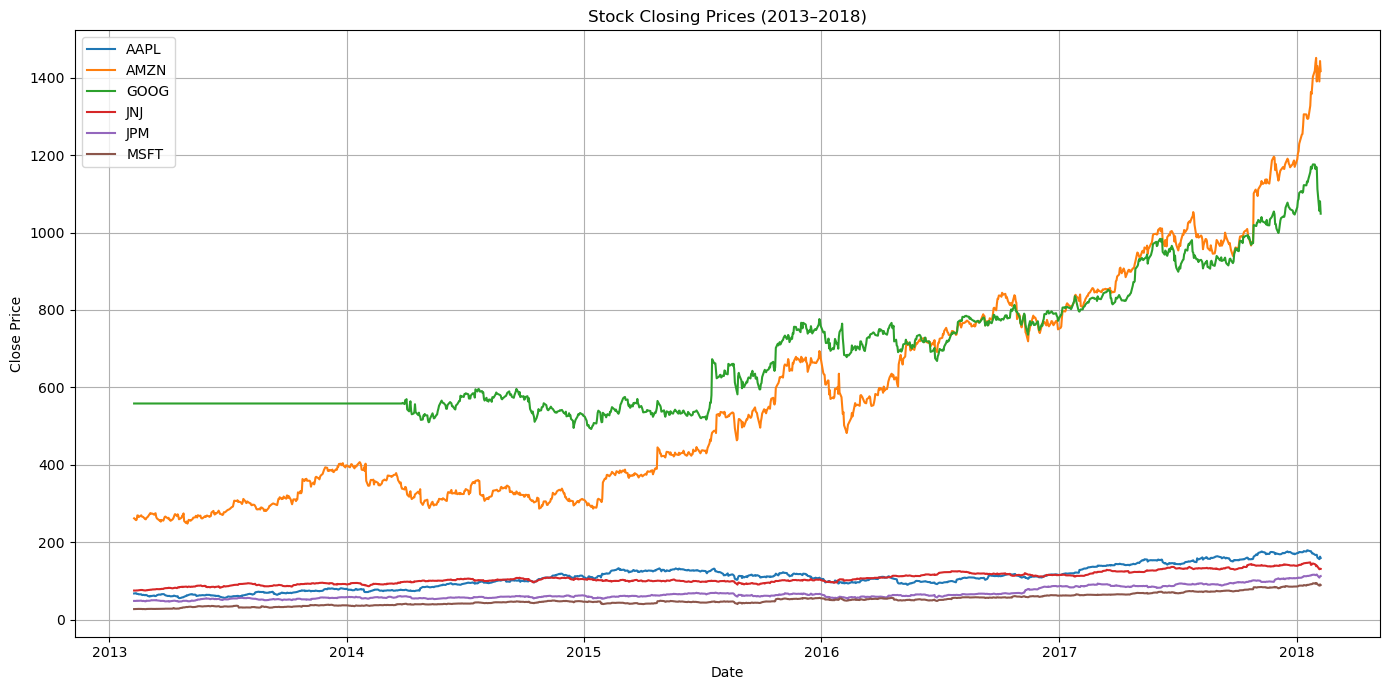

In [5]:
# Plot closing prices of all 6 companies over time
plt.figure(figsize=(14, 7))
for ticker in df_wide_interpolated.columns:
    plt.plot(df_wide_interpolated.index, df_wide_interpolated[ticker], label=ticker)

plt.title("Stock Closing Prices (2013–2018)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


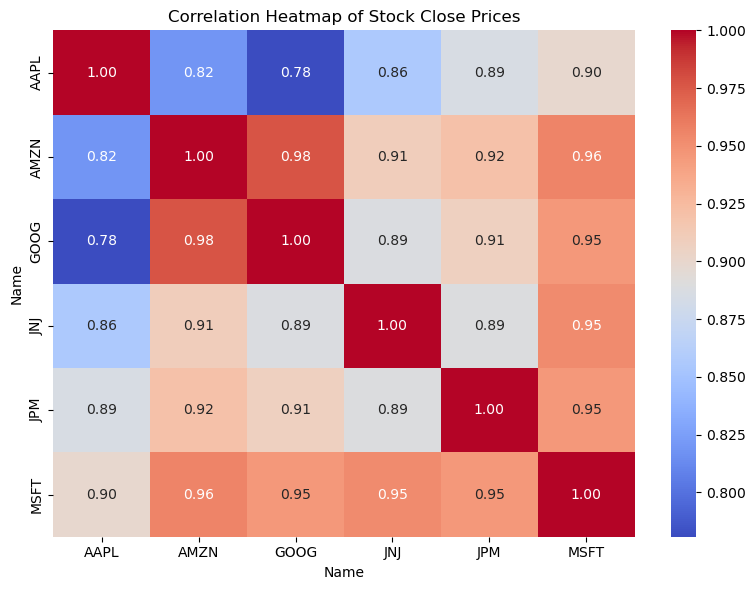

In [7]:
# Correlation matrix of stock prices
plt.figure(figsize=(8, 6))
sns.heatmap(df_wide_interpolated.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stock Close Prices")
plt.tight_layout()
plt.show()


In [9]:
# Function to perform Augmented Dickey-Fuller Test
def adf_test(series, name):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series, autolag='AIC')
    print(f"ADF Test for {name}:")
    print(f"  Test Statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    if result[1] <= 0.05:
        print("  => Stationary ")
    else:
        print("  => Non-stationary ")
    print("-" * 40)

# Run ADF test on each stock
for col in df_wide_interpolated.columns:
    adf_test(df_wide_interpolated[col], col)


ADF Test for AAPL:
  Test Statistic : -0.6651
  p-value        : 0.8556
  => Non-stationary 
----------------------------------------
ADF Test for AMZN:
  Test Statistic : 2.4838
  p-value        : 0.9990
  => Non-stationary 
----------------------------------------
ADF Test for GOOG:
  Test Statistic : 0.0543
  p-value        : 0.9628
  => Non-stationary 
----------------------------------------
ADF Test for JNJ:
  Test Statistic : -1.5078
  p-value        : 0.5296
  => Non-stationary 
----------------------------------------
ADF Test for JPM:
  Test Statistic : 0.8152
  p-value        : 0.9919
  => Non-stationary 
----------------------------------------
ADF Test for MSFT:
  Test Statistic : 0.4157
  p-value        : 0.9821
  => Non-stationary 
----------------------------------------


In [11]:
# Apply first-order differencing
df_diff = df_wide_interpolated.diff().dropna()

# ADF test after differencing
print("ADF Test After First Differencing:\n")
for col in df_diff.columns:
    adf_test(df_diff[col], col)


ADF Test After First Differencing:

ADF Test for AAPL:
  Test Statistic : -34.8201
  p-value        : 0.0000
  => Stationary 
----------------------------------------
ADF Test for AMZN:
  Test Statistic : -21.3659
  p-value        : 0.0000
  => Stationary 
----------------------------------------
ADF Test for GOOG:
  Test Statistic : -33.1819
  p-value        : 0.0000
  => Stationary 
----------------------------------------
ADF Test for JNJ:
  Test Statistic : -14.3999
  p-value        : 0.0000
  => Stationary 
----------------------------------------
ADF Test for JPM:
  Test Statistic : -35.0802
  p-value        : 0.0000
  => Stationary 
----------------------------------------
ADF Test for MSFT:
  Test Statistic : -36.4803
  p-value        : 0.0000
  => Stationary 
----------------------------------------


<Figure size 1200x800 with 0 Axes>

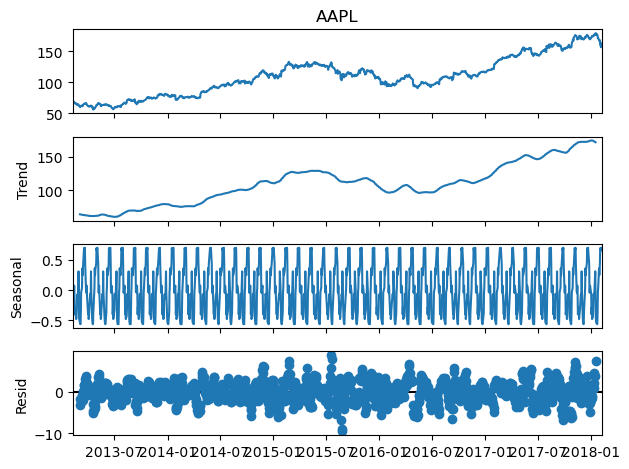

<Figure size 1200x800 with 0 Axes>

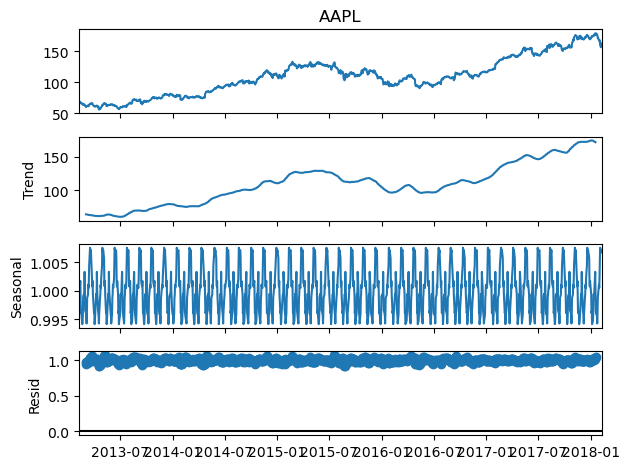

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Use the original (non-differenced) series for decomposition
ts = df_wide_interpolated['AAPL']

# Apply additive decomposition
additive_result = seasonal_decompose(ts, model='additive', period=30)  # monthly seasonality

# Apply multiplicative decomposition
multiplicative_result = seasonal_decompose(ts, model='multiplicative', period=30)

# Plot both
plt.figure(figsize=(12, 8))
plt.suptitle("AAPL Additive Decomposition", fontsize=14)
additive_result.plot()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.suptitle("AAPL Multiplicative Decomposition", fontsize=14)
multiplicative_result.plot()
plt.tight_layout()
plt.show()


ARIMA Model Evaluation (AAPL):
RMSE      : 27.25
MAE       : 24.32
MAPE (%)  : nan
MSE       : 742.48


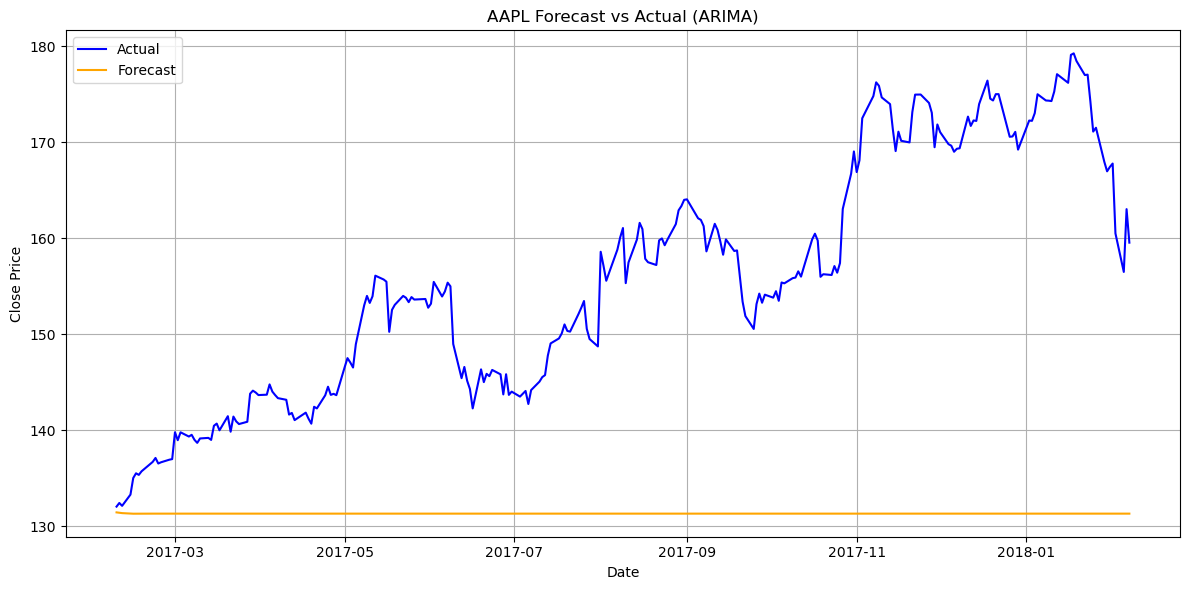

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and prepare data
df = pd.read_csv("all_stocks_5yr.csv")
df['date'] = pd.to_datetime(df['date'])
selected = df[df['Name'].isin(['AAPL'])]
aapl_series = selected.pivot(index='date', columns='Name', values='close')['AAPL'].interpolate(method='linear')

# Split into training and testing sets (80/20)
train_size = int(len(aapl_series) * 0.8)
train = aapl_series[:train_size]
test = aapl_series[train_size:]

# Fit ARIMA(5,1,0)
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# Forecast over test set length
forecast = model_fit.forecast(steps=len(test))

# Evaluate forecast accuracy
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)

mape = np.mean(np.abs((test - forecast) / np.maximum(test, 1))) * 100
mse = mean_squared_error(test, forecast)

# Print evaluation
print("ARIMA Model Evaluation (AAPL):")
print(f"RMSE      : {rmse:.2f}")
print(f"MAE       : {mae:.2f}")
print(f"MAPE (%)  : {mape:.2f}")
print(f"MSE       : {mse:.2f}")

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title("AAPL Forecast vs Actual (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
!pip install pmdarima


   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   -- ------------------------------------- 41.0/625.1 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 9.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----------------------- ---------------- 1.6/2.8 MB 50.2 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 44.2 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3666.849, Time=1.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3660.351, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3661.845, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3661.831, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3660.166, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3663.145, Time=0.69 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.876 seconds
Auto ARIMA Evaluation:
RMSE      : 27.05
MAE       : 24.10
MAPE (%)  : nan
MSE       : 731.74


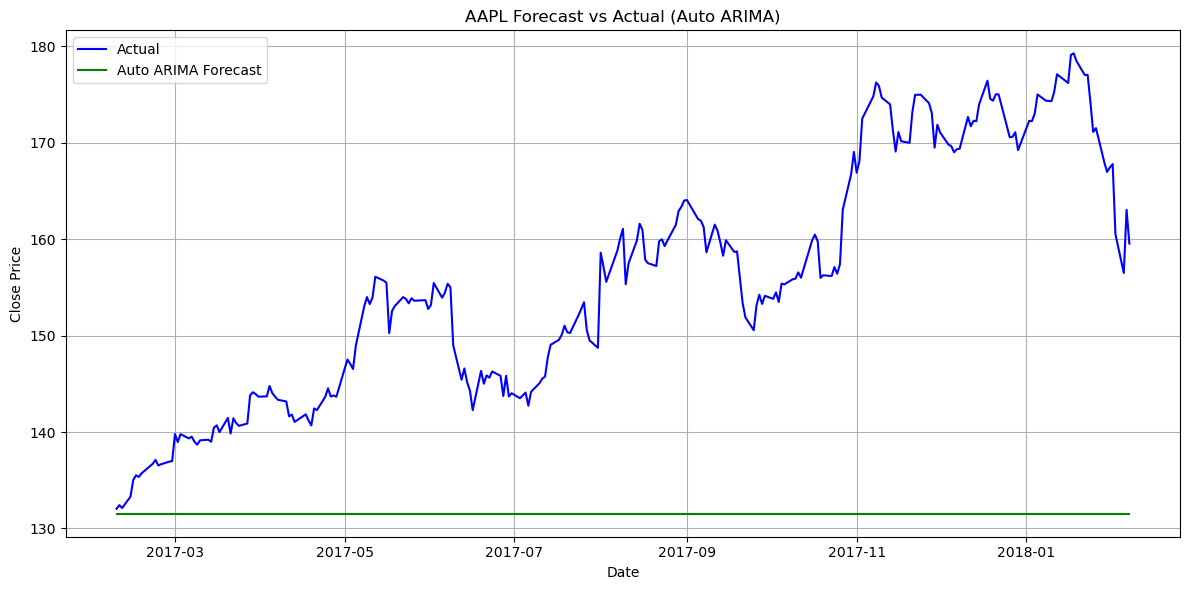

In [18]:
# Install this first if not already installed
# !pip install pmdarima

from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Fit auto ARIMA model to training data
auto_model = auto_arima(train, seasonal=False, stepwise=True, trace=True,
                        error_action='ignore', suppress_warnings=True)

# Forecast on test set
forecast_auto = auto_model.predict(n_periods=len(test))

# Evaluation metrics
rmse_auto = np.sqrt(mean_squared_error(test, forecast_auto))
mae_auto = mean_absolute_error(test, forecast_auto)
mape_auto = np.mean(np.abs((test - forecast_auto) / np.maximum(test, 1))) * 100
mse_auto = mean_squared_error(test, forecast_auto)

print("Auto ARIMA Evaluation:")
print(f"RMSE      : {rmse_auto:.2f}")
print(f"MAE       : {mae_auto:.2f}")
print(f"MAPE (%)  : {mape_auto:.2f}")
print(f"MSE       : {mse_auto:.2f}")

# Plot actual vs. forecast
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast_auto, label='Auto ARIMA Forecast', color='green')
plt.title("AAPL Forecast vs Actual (Auto ARIMA)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ETS Model Evaluation (AAPL):
RMSE      : 18.00
MAE       : 15.97
MAPE (%)  : nan
MSE       : 324.01


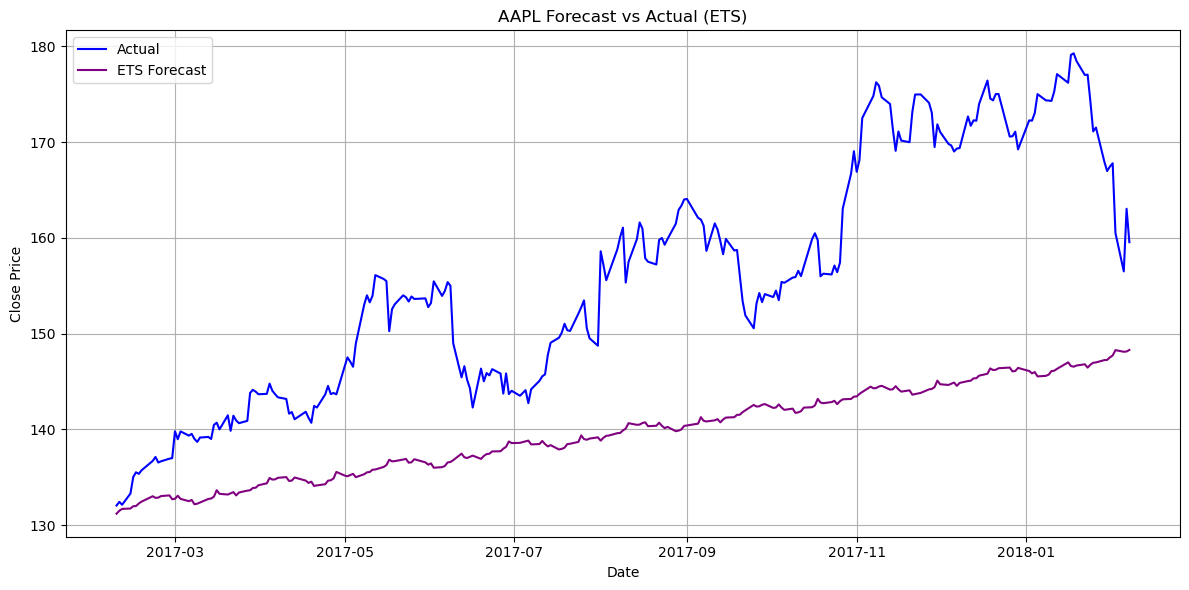

In [21]:
# Phase 3: Forecasting Models – ETS (Exponential Smoothing)
# Model: Holt-Winters with trend and seasonality

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Use the same train/test split from earlier
# train, test already defined from ARIMA step

# Fit Holt-Winters ETS model
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=30)
ets_fit = ets_model.fit()

# Forecast over test set
ets_forecast = ets_fit.forecast(steps=len(test))

# Evaluation metrics
rmse_ets = np.sqrt(mean_squared_error(test, ets_forecast))
mae_ets = mean_absolute_error(test, ets_forecast)
mape_ets = np.mean(np.abs((test - ets_forecast) / np.maximum(test, 1))) * 100
mse_ets = mean_squared_error(test, ets_forecast)

# Print evaluation
print("ETS Model Evaluation (AAPL):")
print(f"RMSE      : {rmse_ets:.2f}")
print(f"MAE       : {mae_ets:.2f}")
print(f"MAPE (%)  : {mape_ets:.2f}")
print(f"MSE       : {mse_ets:.2f}")

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, ets_forecast, label='ETS Forecast', color='purple')
plt.title("AAPL Forecast vs Actual (ETS)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


17:02:29 - cmdstanpy - INFO - Chain [1] start processing
17:02:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Evaluation (AAPL):
RMSE      : 28.73
MAE       : 27.36
MAPE (%)  : 17.26
MSE       : 825.26


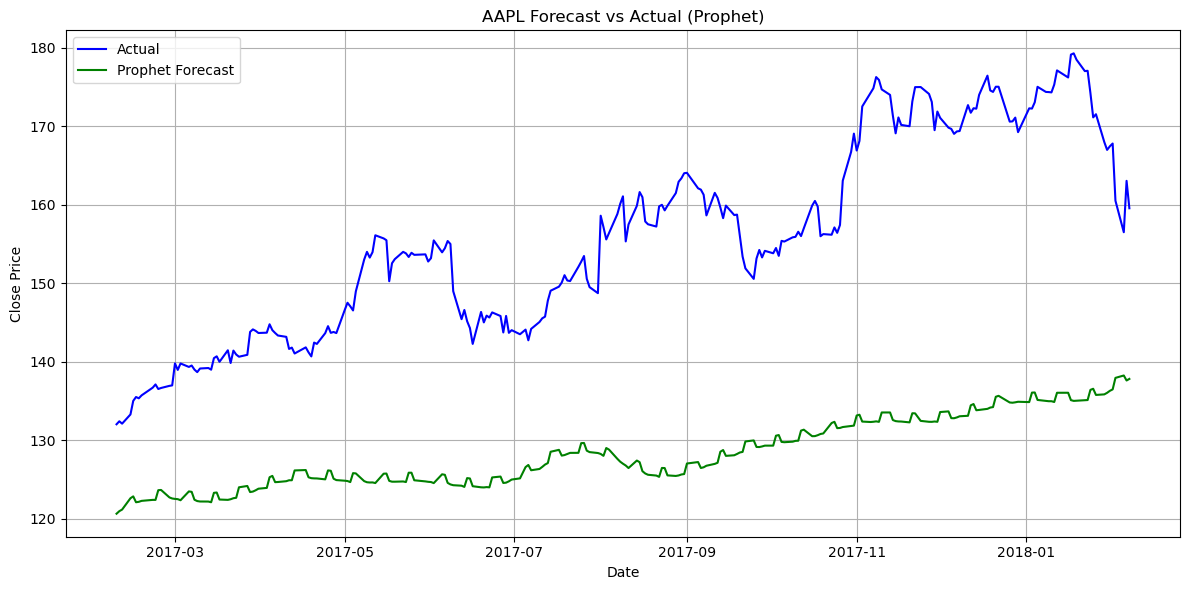

In [26]:
# Phase 3: Forecasting Models – Prophet
# Prophet is great for capturing trend + seasonality with interpretable components

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Prepare AAPL data in Prophet format
aapl_prophet = aapl_series.reset_index()
aapl_prophet.columns = ['ds', 'y']

# Split into train/test (80/20)
train_size = int(len(aapl_prophet) * 0.8)
train_df = aapl_prophet[:train_size]
test_df = aapl_prophet[train_size:]

# Initialize and fit Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train_df)

# Make future dataframe for test horizon
future = prophet_model.make_future_dataframe(periods=len(test_df), freq='D')

# Predict
forecast_prophet = prophet_model.predict(future)

# Extract predicted values for test range
forecast_values = forecast_prophet.iloc[-len(test_df):]['yhat'].values

# Evaluation
rmse_prophet = np.sqrt(mean_squared_error(test_df['y'], forecast_values))
mae_prophet = mean_absolute_error(test_df['y'], forecast_values)
mape_prophet = np.mean(np.abs((test_df['y'] - forecast_values) / np.maximum(test_df['y'], 1))) * 100
mse_prophet = mean_squared_error(test_df['y'], forecast_values)

print("Prophet Model Evaluation (AAPL):")
print(f"RMSE      : {rmse_prophet:.2f}")
print(f"MAE       : {mae_prophet:.2f}")
print(f"MAPE (%)  : {mape_prophet:.2f}")
print(f"MSE       : {mse_prophet:.2f}")

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', color='blue')
plt.plot(test_df['ds'], forecast_values, label='Prophet Forecast', color='green')
plt.title("AAPL Forecast vs Actual (Prophet)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
!pip install prophet


   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/13.3 MB 24.8 MB/s eta 0:00:01
   ------ --------------------------------- 2.3/13.3 MB 28.9 MB/s eta 0:00:01
   ---------- ----------------------------- 3.5/13.3 MB 28.2 MB/s eta 0:00:01
   -------------- ------------------------- 4.8/13.3 MB 27.7 MB/s eta 0:00:01
   ----------------- ---------------------- 5.7/13.3 MB 26.0 MB/s eta 0:00:01
   -------------------- ------------------- 6.9/13.3 MB 25.8 MB/s eta 0:00:01
   ------------------------ --------------- 8.0/13.3 MB 25.6 MB/s eta 0:00:01
   ------------------------- -------------- 8.7/13.3 MB 24.1 MB/s eta 0:00:01
   ----------------------------- ---------- 9.7/13.3 MB 23.9 MB/s eta 0:00:01
   -------------------------------- ------- 10.9/13.3 MB 25.2 MB/s eta 0:00:01
   ----------------------------------- ---- 11.7/13.3 MB 23.4 MB/s eta 0:00:01
   -------------------------------------- - 12.9/13.3 MB 22.6 MB/s eta

Using lag: 5
VAR Model Evaluation (AAPL - differenced):
RMSE      : 1.88
MAE       : 1.29
MAPE (%)  : 97.45
MSE       : 3.52


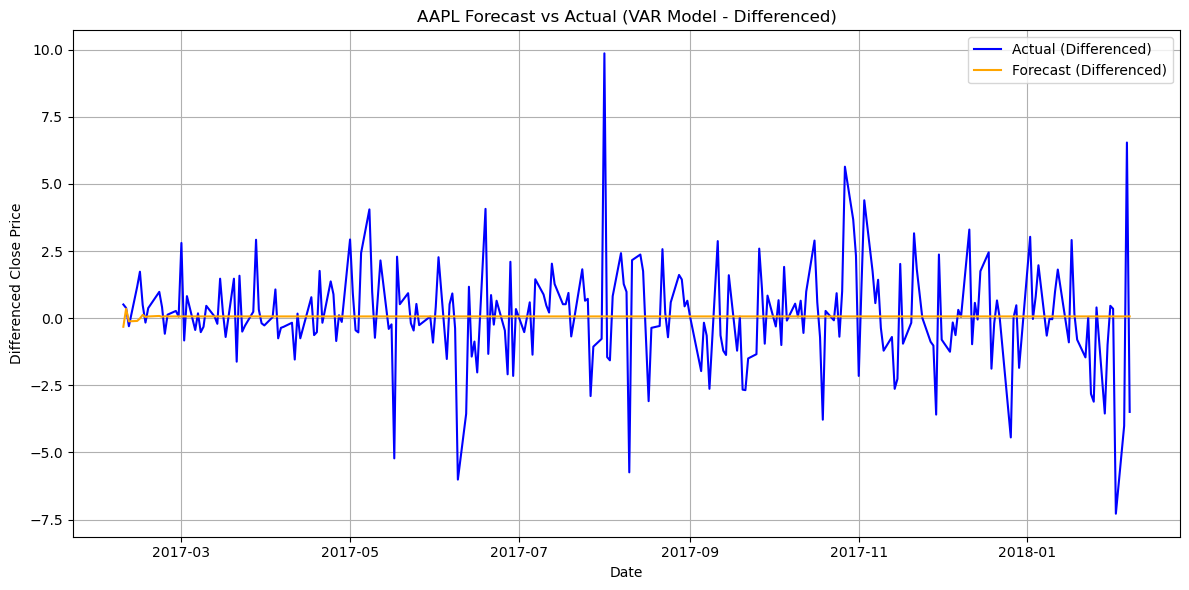

In [31]:
# Phase 3: Forecasting Models – VAR (Multivariate Forecasting)
# Implements multivariate time series model as required by professor (VARIMA/VAR)

from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Step 1: First-differenced multivariate data (already interpolated)
df_diff = df_wide_interpolated.diff().dropna()

# Step 2: Split into train/test (80/20)
train_size = int(len(df_diff) * 0.8)
train_var = df_diff.iloc[:train_size]
test_var = df_diff.iloc[train_size:]

# Step 3: Select optimal lag using AIC
model = VAR(train_var)
lag_order = model.select_order(maxlags=15)
best_lag = lag_order.selected_orders['aic']

# 🛠 Fix for lag=0 or None
if best_lag is None or best_lag == 0:
    best_lag = 5  # default lag
print("Using lag:", best_lag)

# Step 4: Fit VAR model
var_model = model.fit(best_lag)

# Step 5: Forecast the number of steps in test set
forecast_input = train_var.values[-best_lag:]
forecast_output = var_model.forecast(y=forecast_input, steps=len(test_var))
forecast_df = pd.DataFrame(forecast_output, index=test_var.index, columns=test_var.columns)

# Step 6: Evaluate forecast performance for AAPL (in differenced scale)
rmse_var = np.sqrt(mean_squared_error(test_var['AAPL'], forecast_df['AAPL']))
mae_var = mean_absolute_error(test_var['AAPL'], forecast_df['AAPL'])
mape_var = np.mean(np.abs((test_var['AAPL'] - forecast_df['AAPL']) / np.maximum(test_var['AAPL'], 1))) * 100
mse_var = mean_squared_error(test_var['AAPL'], forecast_df['AAPL'])

print("VAR Model Evaluation (AAPL - differenced):")
print(f"RMSE      : {rmse_var:.2f}")
print(f"MAE       : {mae_var:.2f}")
print(f"MAPE (%)  : {mape_var:.2f}")
print(f"MSE       : {mse_var:.2f}")

# Step 7: Plot forecast vs actual (AAPL - differenced values)
plt.figure(figsize=(12, 6))
plt.plot(test_var.index, test_var['AAPL'], label='Actual (Differenced)', color='blue')
plt.plot(test_var.index, forecast_df['AAPL'], label='Forecast (Differenced)', color='orange')
plt.title("AAPL Forecast vs Actual (VAR Model - Differenced)")
plt.xlabel("Date")
plt.ylabel("Differenced Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
LSTM Model Evaluation (AAPL):
RMSE      : 3.83
MAE       : 2.95
MAPE (%)  : 1.85
MSE       : 14.63


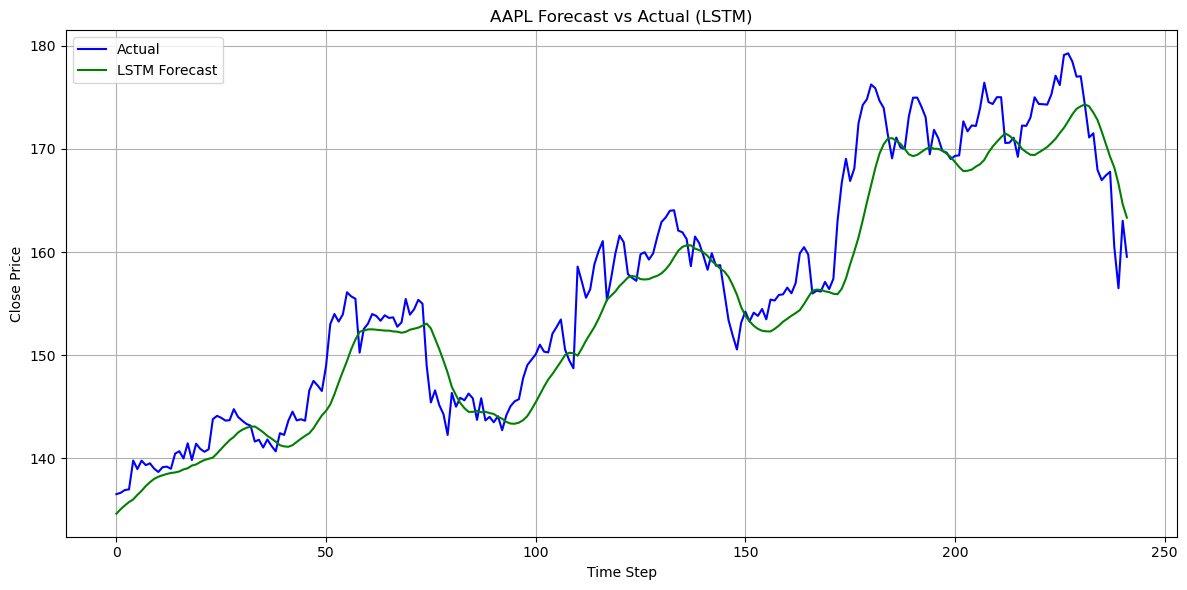

In [33]:
# Phase 3: Bonus Model – LSTM Forecasting for AAPL
# Based on lecture examples and textbook format

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Step 1: Prepare AAPL series
aapl_lstm = aapl_series.values.reshape(-1, 1)  # reshape for scaler

# Step 2: Normalize data (LSTM needs scaled input)
scaler = MinMaxScaler()
aapl_scaled = scaler.fit_transform(aapl_lstm)

# Step 3: Train-test split
train_size = int(len(aapl_scaled) * 0.8)
train_data = aapl_scaled[:train_size]
test_data = aapl_scaled[train_size:]

# Step 4: Create sequences for LSTM
def create_sequences(data, lookback=10):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 10
X_train, y_train = create_sequences(train_data, lookback)
X_test, y_test = create_sequences(test_data, lookback)

# Step 5: Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Step 7: Predict
predictions = model.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Step 8: Evaluation
rmse_lstm = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
mae_lstm = mean_absolute_error(y_test_inverse, predictions_inverse)
mape_lstm = np.mean(np.abs((y_test_inverse - predictions_inverse) / np.maximum(y_test_inverse, 1))) * 100
mse_lstm = mean_squared_error(y_test_inverse, predictions_inverse)

print("LSTM Model Evaluation (AAPL):")
print(f"RMSE      : {rmse_lstm:.2f}")
print(f"MAE       : {mae_lstm:.2f}")
print(f"MAPE (%)  : {mape_lstm:.2f}")
print(f"MSE       : {mse_lstm:.2f}")

# Step 9: Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test_inverse, label='Actual', color='blue')
plt.plot(predictions_inverse, label='LSTM Forecast', color='green')
plt.title("AAPL Forecast vs Actual (LSTM)")
plt.xlabel("Time Step")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
